In [1]:
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [2]:
cv.__version__

'3.3.0'

In [3]:
!ls -lht /Users/tejaswin.p/Downloads/herzjesu_dense/

total 0
drwxr-xr-x@ 10 tejaswin.p  1493847943   320B Oct  3 01:58 urd


In [4]:
img1 = cv.imread('/Users/tejaswin.p/Downloads/fountain-p11/0000.jpg',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('/Users/tejaswin.p/Downloads/fountain-p11/0002.jpg',cv.IMREAD_GRAYSCALE) # trainImage

img1 = cv.resize(img1, None, fx=0.2, fy=0.2)
img2 = cv.resize(img2, None, fx=0.2, fy=0.2)

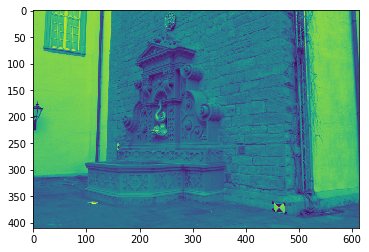

In [5]:
plt.imshow(img1)

In [6]:
img1.shape

(410, 614)

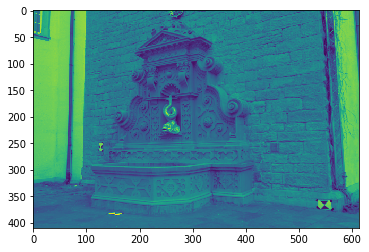

In [7]:
plt.imshow(img2)

In [8]:
img1.shape

(410, 614)

In [9]:
points = np.eye(3) * 10

In [10]:
# import pptk
# v = pptk.viewer(points, [10, 10, 10])
# v.set(point_size=0.5)

## point matching

(100, 100)
(76, 76)


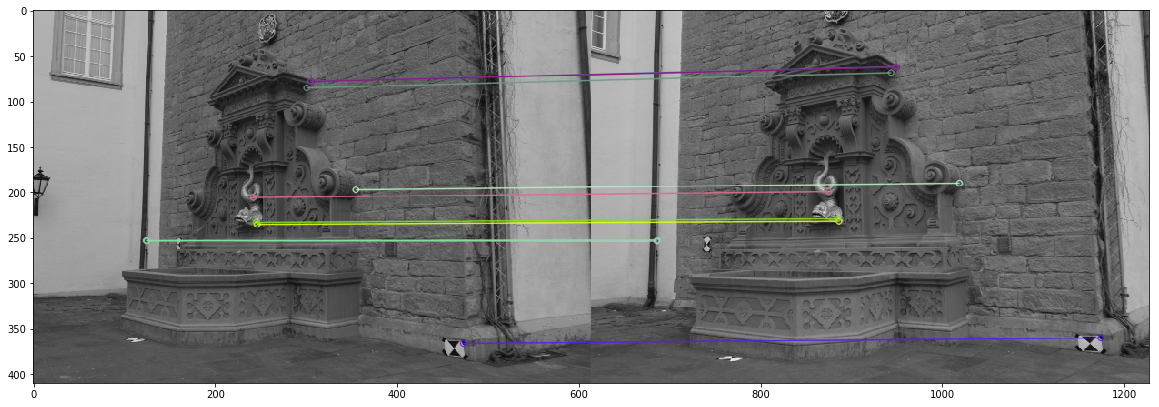

In [11]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bfmatcher = cv.BFMatcher(cv.NORM_HAMMING2, crossCheck=True)

matches = bfmatcher.match(des1, des2)
matches = sorted(matches, key = lambda x : x.distance)

img_match_orb = cv.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

plt.figure(figsize=(20, 10))
plt.imshow(img_match_orb)

pts1, pts2 = [], []
for i, m in enumerate(matches[:100]):
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)

print(len(pts1), len(pts2))

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

print(len(pts1), len(pts2))

## draw epilines

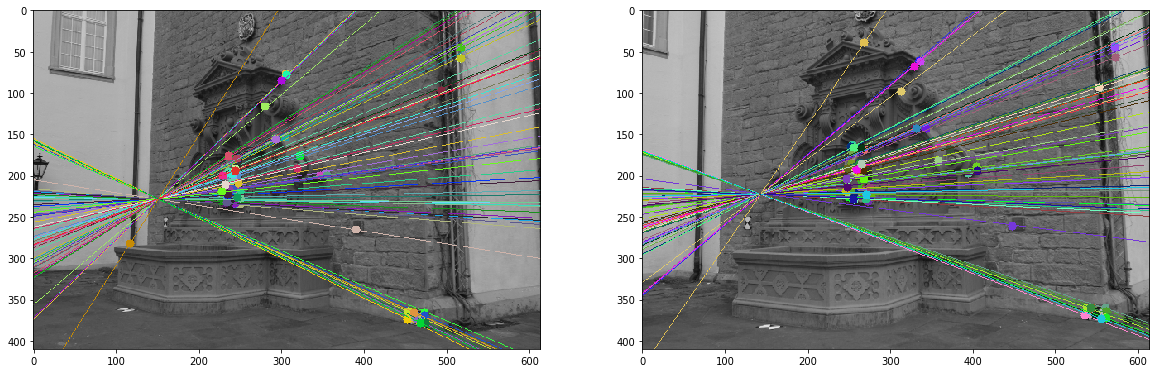

In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)


plt.figure(figsize=(20, 10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## essential

In [13]:
K = np.array([
    [2759.48, 0, 1520.69],
    [0, 2764.16, 1006.81], 
    [0, 0, 1]
])

In [14]:
F

array([[ -3.15685715e-07,  -6.58493755e-05,   1.50957878e-02],
       [  8.25471328e-05,   7.55761651e-06,  -1.41821287e-02],
       [ -1.83286136e-02,   7.72563648e-03,   1.00000000e+00]])

In [15]:
E, mask = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC)

In [16]:
E

array([[-0.3054063 , -0.38795181, -0.41973458],
       [-0.21279821,  0.37503204, -0.43223511],
       [ 0.01940448,  0.45013201, -0.06548742]])

In [17]:
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [18]:
len(pts1), len(pts2)

(57, 57)

## projection mats

In [61]:
D = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
])

u, _, vh = np.linalg.svd(E)
t = u[:, -1]

aR = np.dot(u, D).dot(vh)
bR = np.dot(u, np.linalg.inv(D)).dot(vh)

In [65]:
aR

array([[-0.12358799, -0.68229466,  0.72055535],
       [ 0.08723468, -0.73078095, -0.677015  ],
       [-0.98849184,  0.02081351, -0.14983551]])

In [66]:
bR

array([[-0.55642393,  0.77158627, -0.308297  ],
       [ 0.77013306,  0.61820095,  0.1572344 ],
       [-0.3119094 ,  0.14994073,  0.93820589]])

In [76]:
linear_LS_triangulation_C = -np.eye(2, 3)

def linear_LS_triangulation(u1, P1, u2, P2):
    output_dtype = float
    """
    Linear Least Squares based triangulation.
    Relative speed: 0.1
    
    (u1, P1) is the reference pair containing normalized image coordinates (x, y) and the corresponding camera matrix.
    (u2, P2) is the second pair.
    
    u1 and u2 are matrices: amount of points equals #rows and should be equal for u1 and u2.
    
    The status-vector will be True for all points.
    """
    A = np.zeros((4, 3))
    b = np.zeros((4, 1))
    
    # Create array of triangulated points
    x = np.zeros((3, len(u1)))
    
    # Initialize C matrices
    C1 = np.array(linear_LS_triangulation_C)
    C2 = np.array(linear_LS_triangulation_C)
    
    for i in range(len(u1)):
        # Derivation of matrices A and b:
        # for each camera following equations hold in case of perfect point matches:
        #     u.x * (P[2,:] * x)     =     P[0,:] * x
        #     u.y * (P[2,:] * x)     =     P[1,:] * x
        # and imposing the constraint:
        #     x = [x.x, x.y, x.z, 1]^T
        # yields:
        #     (u.x * P[2, 0:3] - P[0, 0:3]) * [x.x, x.y, x.z]^T     +     (u.x * P[2, 3] - P[0, 3]) * 1     =     0
        #     (u.y * P[2, 0:3] - P[1, 0:3]) * [x.x, x.y, x.z]^T     +     (u.y * P[2, 3] - P[1, 3]) * 1     =     0
        # and since we have to do this for 2 cameras, and since we imposed the constraint,
        # we have to solve 4 equations in 3 unknowns (in LS sense).

        # Build C matrices, to construct A and b in a concise way
        C1[:, 2] = u1[i, :]
        C2[:, 2] = u2[i, :]
        
        # Build A matrix:
        # [
        #     [ u1.x * P1[2,0] - P1[0,0],    u1.x * P1[2,1] - P1[0,1],    u1.x * P1[2,2] - P1[0,2] ],
        #     [ u1.y * P1[2,0] - P1[1,0],    u1.y * P1[2,1] - P1[1,1],    u1.y * P1[2,2] - P1[1,2] ],
        #     [ u2.x * P2[2,0] - P2[0,0],    u2.x * P2[2,1] - P2[0,1],    u2.x * P2[2,2] - P2[0,2] ],
        #     [ u2.y * P2[2,0] - P2[1,0],    u2.y * P2[2,1] - P2[1,1],    u2.y * P2[2,2] - P2[1,2] ]
        # ]
        A[0:2, :] = C1.dot(P1[0:3, 0:3])    # C1 * R1
        A[2:4, :] = C2.dot(P2[0:3, 0:3])    # C2 * R2
        
        # Build b vector:
        # [
        #     [ -(u1.x * P1[2,3] - P1[0,3]) ],
        #     [ -(u1.y * P1[2,3] - P1[1,3]) ],
        #     [ -(u2.x * P2[2,3] - P2[0,3]) ],
        #     [ -(u2.y * P2[2,3] - P2[1,3]) ]
        # ]
        b[0:2, :] = C1.dot(P1[0:3, 3:4])    # C1 * t1
        b[2:4, :] = C2.dot(P2[0:3, 3:4])    # C2 * t2
        b *= -1
        
        # Solve for x vector
        cv.solve(A, b, x[:, i:i+1], cv.DECOMP_SVD)
    
    return x.T.astype(output_dtype), np.ones(len(u1), dtype=bool)

In [124]:
for i, (rot, tran) in enumerate([(aR, t), (aR, -t), (bR, t), (bR, -t)]):
    proj1 = np.concatenate([np.eye(3), np.zeros((3, 1))], axis=-1)
    proj2 = np.concatenate([rot, np.expand_dims(tran, -1)], axis=-1)
    
#     points3d = cv.triangulatePoints(proj1, proj2, pts1[:10].T, pts2[:10].T)
#     points3d = points3d/points3d[-1]

##    CUSTOM!

    normpts1 = cv.undistortPoints(np.expand_dims(pts1, 0).astype(np.float32), K, None)
    normpts2 = cv.undistortPoints(np.expand_dims(pts2, 0).astype(np.float32), K, None)
    points3d = linear_LS_triangulation(normpts1.squeeze(), proj1, normpts2.squeeze(), proj2)[0]
    
    print i
    print points3d[:5]
    print np.alltrue(points3d[:, -1]>0)
    print

0
[[-0.28561889 -0.21808328  0.64832287]
 [-0.28541251 -0.21788236  0.64836886]
 [-0.25243577 -0.15405478  0.66498243]
 [-0.31200441 -0.19507822  0.67289876]
 [-0.31217829 -0.18872354  0.6757831 ]]
True

1
[[ 0.28561889  0.21808328 -0.64832287]
 [ 0.28541251  0.21788236 -0.64836886]
 [ 0.25243577  0.15405478 -0.66498243]
 [ 0.31200441  0.19507822 -0.67289876]
 [ 0.31217829  0.18872354 -0.6757831 ]]
False

2
[[-2.72613416 -2.08152993  6.18801896]
 [-2.73090219 -2.08475578  6.20376404]
 [-3.16219317 -1.92979653  8.33003846]
 [-1.73267076 -1.08333713  3.73684252]
 [-1.6896735  -1.02147119  3.65769428]]
True

3
[[ 2.72613416  2.08152993 -6.18801896]
 [ 2.73090219  2.08475578 -6.20376404]
 [ 3.16219317  1.92979653 -8.33003846]
 [ 1.73267076  1.08333713 -3.73684252]
 [ 1.6896735   1.02147119 -3.65769428]]
False



In [125]:
pts1.T.astype(np.float32)

array([[ 305.,  306.,  473.,  241.,  246.,  300.,  354.,  245.,  228.,
         459.,  234.,  390.,  250.,  247.,  280.,  237.,  463.,  236.,
         233.,  240.,  241.,  238.,  236.,  453.,  250.,  232.,  244.,
         247.,  244.,  233.,  230.,  247.,  228.,  234.,  236.,  245.,
         234.,  238.,  234.,  474.,  241.,  248.,  246.,  234.,  235.,
         250.,  319.,  242.,  237.,  235.,  293.,  232.,  228.,  247.,
         468.,  229.,  244.],
       [  77.,   78.,  366.,  205.,  235.,   85.,  197.,  233.,  229.,
         365.,  226.,  265.,  234.,  229.,  116.,  176.,  374.,  176.,
         226.,  199.,  217.,  180.,  195.,  364.,  229.,  233.,  233.,
         179.,  216.,  217.,  224.,  200.,  231.,  217.,  177.,  191.,
         226.,  231.,  226.,  378.,  216.,  209.,  179.,  232.,  223.,
         227.,  191.,  199.,  217.,  222.,  156.,  211.,  219.,  226.,
         378.,  200.,  194.]], dtype=float32)

In [126]:
proj2 = np.concatenate([bR, np.expand_dims(-t, -1)], axis=-1)

In [127]:
proj2

array([[-0.55642393,  0.77158627, -0.308297  ,  0.40010816],
       [ 0.77013306,  0.61820095,  0.1572344 , -0.50446149],
       [-0.3119094 ,  0.14994073,  0.93820589,  0.76513533]])

In [128]:
tripoints = linear_LS_triangulation(pts1, proj1, pts2, proj2)[0]

# tripoints = cv.triangulatePoints(proj1, proj2, pts1[:10].T, pts2[:10].T)
# tripoints = tripoints/tripoints[-1]

In [129]:
tripoints[:10]

array([[ 2.20713378, -0.57246688,  0.006319  ],
       [ 2.20748998, -0.57139799,  0.00628855],
       [ 2.28989216, -0.35992564,  0.00263789],
       [ 2.3598145 , -0.22874276,  0.00512847],
       [ 2.38244834, -0.17576088,  0.00463024],
       [ 2.21337967, -0.55892719,  0.00629905],
       [ 2.26266838, -0.43291714,  0.00432119],
       [ 2.38059304, -0.17994657,  0.00465792],
       [ 2.40290354, -0.13291409,  0.00486819],
       [ 2.29447719, -0.3503431 ,  0.00266733]])

In [130]:
import pptk
v = pptk.viewer(tripoints[:3])
v.set(point_size=0.005)

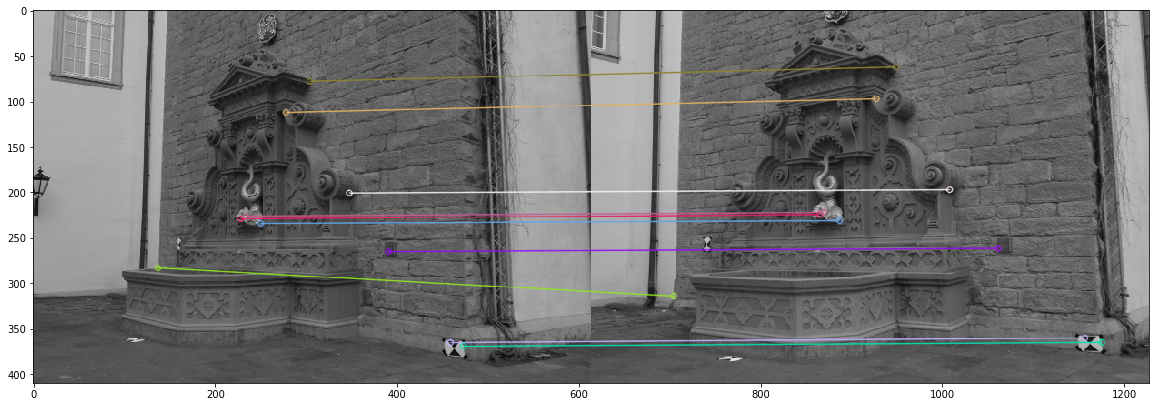

In [131]:
img_match_orb = cv.drawMatches(img1, kp1, img2, kp2, matches[10:20], None, flags=2)

plt.figure(figsize=(20, 10))
plt.imshow(img_match_orb)

In [132]:
import csv
with open('test_points.csv', 'w') as fp:
    writer = csv.writer(fp, delimiter=' ')
    writer.writerows(tripoints)

In [133]:
proj1

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

In [134]:
proj2

array([[-0.55642393,  0.77158627, -0.308297  ,  0.40010816],
       [ 0.77013306,  0.61820095,  0.1572344 , -0.50446149],
       [-0.3119094 ,  0.14994073,  0.93820589,  0.76513533]])